# Exploration of the Titanic dataset

### Imports

In [1]:
import pandas as pd
import matplotlib as plt

### Get the data

In [2]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')
gender_submission = pd.read_csv('data/gender_submission.csv')

In [3]:
passenger_id = test.PassengerId

In [4]:
train.shape

(891, 12)

In [5]:
test.shape

(418, 11)

As we can see above, both the train and the test sets are very small (< 1000 examples with 11 features).  
We will study them thoroughly in order to understand each feature's importance and how to use it in order to classify each passenger.   

## Dive in

### Global approach

In [6]:
train.head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


The feature "Survived" will be our target feature in that case : we just need to make sure what kind it is (binary or not). 

In [7]:
(train.Survived.value_counts() / train.shape[0]).plot.bar(color=['#854D27', '#F4C95D']);

As we can see on the plot above : ~60% of the passengers are Survived = 0 and the others are Survived = 1.   
It means that the dataset isn't imbalanced but, we could still balance it to 50/50 if we see that our classification accuracy is bad.

#### Types

In [8]:
train.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

As we can see, only three features are categorical "Name", "Sex" and "Ticket".  
We will need to handle them differently in order to be able to use them.

#### Feature inspection

In [9]:
unique_values_percent = train.nunique() / train.shape[0]
unique_values_percent.name = 'unique_values_percent'

unique_values = train.nunique()
unique_values.name = 'unique_values'

nan_percent = train.isna().sum() / train.shape[0]
nan_percent.name = 'nan_percent'

In [10]:
features_information = pd.DataFrame(data=[unique_values, unique_values_percent, nan_percent]).T
features_information

,unique_values,unique_values_percent,nan_percent
PassengerId,891.0,1.000000,0.000000
Survived,2.0,0.002245,0.000000
Pclass,3.0,0.003367,0.000000
Name,891.0,1.000000,0.000000
Sex,2.0,0.002245,0.000000
Age,88.0,0.098765,0.198653
SibSp,7.0,0.007856,0.000000
Parch,7.0,0.007856,0.000000
Ticket,681.0,0.764310,0.000000
Fare,248.0,0.278339,0.000000


From the table above we can see various interesting and important information : 
 - 2 features **PassengerId** and **Name** contain completely unique values, thus, there is no point in using them from classification as they carry no information.
 - Only 3 features contain missing values, **Cabin**, **Age** and **Embarked**. We will need to decide what we do in each case. 
 - **Ticket** feature contains a lot of different values and it might not be a good idea to use this variable.

Also, the features "SibSp" and "Parch" combine contain the size of the family of said passenger.  
Combining them to make a variable will be interesting for our model.

#### Dropping useless variables

In [11]:
train_cleaned = train.copy().drop(['PassengerId'], axis=1)

In [12]:
train_cleaned.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


As we can see above, the feature Name seems to contain relevant information on the passenger : his status (Mrs, Ms, Mr...).  
We are going to extract this variable and use it for our analysis.

### Feature focus

##### Name

As we explained it above, we are going to extract information from the name.

In [13]:
status_passenger = train_cleaned.Name.apply(lambda x: x.split('.')[0].split(' ')[-1])

In [14]:
train_cleaned = train_cleaned.assign(status_passenger=status_passenger)

In [15]:
train_cleaned.status_passenger.value_counts()

Mr          517
Miss        182
Mrs         125
Master       40
Dr            7
Rev           6
Col           2
Mlle          2
Major         2
Don           1
Mme           1
Ms            1
Jonkheer      1
Capt          1
Sir           1
Countess      1
Lady          1
Name: status_passenger, dtype: int64

In [16]:
train_cleaned.status_passenger = train_cleaned.status_passenger.replace({'Mme': 'Mrs', 'Ms': 'Miss', 'Mlle': 'Miss'})
train_cleaned.status_passenger = train_cleaned.status_passenger.replace(['Dr', 'Rev', 'Col', 'Major', 'Sir', 'Lady', 'Capt', 'Countess', 'Jonkheer', 'Don'], 'Rare')

In [17]:
train_cleaned.status_passenger.value_counts()

Mr        517
Miss      185
Mrs       126
Master     40
Rare       23
Name: status_passenger, dtype: int64

#### Focus on the variables with missing values

##### Cabin

In [18]:
train_cleaned.Cabin.value_counts()

C23 C25 C27    4
G6             4
B96 B98        4
C22 C26        3
F2             3
              ..
B41            1
E12            1
D50            1
E36            1
C104           1
Name: Cabin, Length: 147, dtype: int64

At first it seems that the "Cabin" feature contains the cabin used by the passenger, but we have this information in only 33% of the cases.  

What we can try, is to see if the cabin information is related in anyway with the survival of the titanic.  

In [19]:
train_cleaned['has_cabin'] = False
train_cleaned.loc[train_cleaned.Cabin.notna(), 'has_cabin'] = True

In [20]:
train_cleaned.groupby('has_cabin').Survived.value_counts()

has_cabin  Survived
False      0           481
           1           206
True       1           136
           0            68
Name: Survived, dtype: int64

In [21]:
train_cleaned.Survived.corr(train_cleaned.has_cabin)

0.3169115231122959

As we can see there seem to be some kind of correlation between the made variable "has_cabin" and our target feature "Survived".  
We will keep it as such for our analysis.

In [22]:
train_cleaned = train_cleaned.drop('Cabin', axis='columns')

##### Age

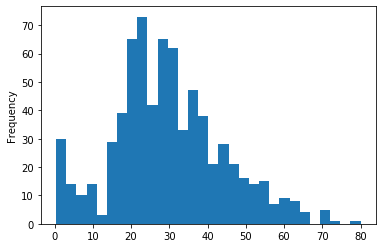

In [23]:
train_cleaned.Age.plot(kind='hist', bins=30);

In [24]:
train_cleaned.Survived.corr(train_cleaned.Age)

-0.07722109457217764

This variable is missing for about 20% of the samples, so we are going to compute the median age for those missing values.

In [25]:
median_age = train_cleaned.Age.median()

In [26]:
train_cleaned['Age'] = train_cleaned.Age.fillna(median_age)

In [27]:
train_cleaned.Survived.corr(train_cleaned.Age)

-0.06491041993052588

##### Embarked

This variable corresponds to the harbour where the passenger got on board from.  
There are three options and a few missing values.  

In [28]:
train_cleaned.Embarked.value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

As we can see above, there seems to be kind of a correlation between embarking at the harbour S and surviving the incident.  
It might be totally random though.

In [29]:
train_cleaned['embarked_s'] = False
train_cleaned['embarked_s'] = train_cleaned.Embarked == 'S'

train_cleaned['embarked_q'] = False
train_cleaned['embarked_q'] = train_cleaned.Embarked == 'Q'

train_cleaned['embarked_c'] = False
train_cleaned['embarked_c'] = train_cleaned.Embarked == 'C'

In [30]:
train_cleaned.Survived.corr(train_cleaned.embarked_s)

-0.15566027340439317

In [31]:
train_cleaned.Survived.corr(train_cleaned.embarked_q)

0.003650382683971961

In [32]:
train_cleaned.Survived.corr(train_cleaned.embarked_c)

0.16824043121823284

Here for the missing values, there is nothing we can do so we are gonna leave them missing.

##### Sex

In [33]:
train_cleaned['sex_male'] = False
train_cleaned['sex_male'] = train_cleaned.Sex == 'male'

In [34]:
train_cleaned.Survived.corr(train_cleaned.sex_male)

-0.543351380657755

As we can see on above, there is a correlation between the sex of the passenger and his survival.

##### Ticket

In [35]:
train_cleaned['Ticket'].value_counts()

CA. 2343           7
1601               7
347082             7
3101295            6
CA 2144            6
                  ..
SOTON/OQ 392090    1
364500             1
SC/PARIS 2133      1
111426             1
PC 17600           1
Name: Ticket, Length: 681, dtype: int64

There seems to be too many different values, and as they occur too few times, they won't carry the necessary information. 

In [36]:
train_cleaned.drop('Ticket', axis='columns', inplace=True)

In [37]:
train_cleaned.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked,status_passenger,has_cabin,embarked_s,embarked_q,embarked_c,sex_male
0,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,7.2500,S,Mr,False,True,False,False,True
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,71.2833,C,Mrs,True,False,False,True,False
2,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,7.9250,S,Miss,False,True,False,False,False
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,53.1000,S,Mrs,True,True,False,False,False
4,0,3,"Allen, Mr. William Henry",male,35.0,0,0,8.0500,S,Mr,False,True,False,False,True


##### Class

In [38]:
train_cleaned.Survived.corr(train_cleaned.Pclass)

-0.33848103596101475

In [39]:
train_cleaned.Pclass.value_counts()

3    491
1    216
2    184
Name: Pclass, dtype: int64

We could make binary variables for the class, but, as it is, there is meaning in keeping it in the numerical way.  
As there is a true difference where 1 > 2 > 3 (or the inverse).  
So we will keep this variable this way.

##### Family size

To compute the family size in a feature, we simply need to add up the values of Parch, SibSp and 1 (corresponding to the passenger). 

In [40]:
train_cleaned['family_size'] = train_cleaned.SibSp + train_cleaned.Parch + 1

In [41]:
train_cleaned.family_size.value_counts()

1     537
2     161
3     102
4      29
6      22
5      15
7      12
11      7
8       6
Name: family_size, dtype: int64

In [42]:
train_cleaned.Survived.corr(train_cleaned.family_size)

0.01663898928274532

There seem to be little to no correlation between this and our target variable Survived.  
Instead, we could use this to express if the passenger is alone or not.

In [43]:
train_cleaned['is_alone'] = train_cleaned.family_size == 1

In [44]:
train_cleaned.Survived.corr(train_cleaned.is_alone)

-0.20336708569989215

Now, as we can see this variable contains much more interesting information.

## Last cleaning touches + applying to the test set

Now that we covered every feature and how they're gonna be used for modeling, we can go ahead and encode them in a way for models to work with them, i.e. numerical variables instead of categorical variables.

There exists various ways of encoding variables : target encoding, one-hot encoding, integer encoding...  
In our case, and because we don't have too many cases for each feature to encode, we will stick to one-hot encoding which consists on making new binary features for each possible value of a categorical feature.  
For example : the feature containing the title of the passenger will become title_mr, title_mlle, title_mrs, etc.  And each new feature is a binary feature containing either a 0 or a 1.  

Thanks to this encoding, we don't lose any information from the variable and allow it to be used in various statistical models.  

### Finish cleaning training data

In [45]:
train_cleaned.head(1)

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked,status_passenger,has_cabin,embarked_s,embarked_q,embarked_c,sex_male,family_size,is_alone
0,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,7.25,S,Mr,False,True,False,False,True,2,False


As we can see, we already did part of the job for **embarked** and **sex**.  

We need to also do the work for our newly made variable **status_passenger**.  

In [46]:
train_cleaned = train_cleaned.join(pd.get_dummies(train_cleaned['status_passenger']))

In [47]:
train_cleaned.columns

Index(['Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare',
       'Embarked', 'status_passenger', 'has_cabin', 'embarked_s', 'embarked_q',
       'embarked_c', 'sex_male', 'family_size', 'is_alone', 'Master', 'Miss',
       'Mr', 'Mrs', 'Rare'],
      dtype='object')

In [48]:
features_to_drop = ['Name', 'Sex', 'SibSp', 'Parch', 'Embarked', 'status_passenger']

In [49]:
train_cleaned = train_cleaned.drop(features_to_drop, axis=1)

In [50]:
train_cleaned = train_cleaned.replace({True: 1, False: 0})

### Clean test data

In [51]:
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [52]:
test['has_cabin'] = False
test['has_cabin'] = test.Cabin.notna()

test['embarked_s'] = False
test['embarked_s'] = test.Embarked == 'S'

test['embarked_q'] = False
test['embarked_q'] = test.Embarked == 'Q'

test['embarked_c'] = False
test['embarked_c'] = test.Embarked == 'C'

test['Age'].fillna(test.Age.median(), inplace=True)

test['sex_male'] = False
test['sex_male'] = test.Sex == 'male'

test['family_size'] = test.SibSp + test .Parch + 1

test['is_alone'] = test.family_size == 1

test_status_passenger = test.Name.apply(lambda x: x.split('.')[0].split(' ')[-1])
test = test.assign(status_passenger=test_status_passenger)
test.status_passenger = test.status_passenger.replace({'Mme': 'Mrs', 'Ms': 'Miss', 'Mlle': 'Miss'})
test.status_passenger = test.status_passenger.replace(['Dona', 'Dr', 'Rev', 'Col', 'Major', 'Sir', 'Lady', 'Capt', 'Countess', 'Jonkheer', 'Don'], 'Rare')

In [53]:
test = test.join(pd.get_dummies(test.status_passenger))

In [54]:
test = test.drop(features_to_drop, axis=1)
test = test.drop(['PassengerId', 'Ticket', 'Cabin'], axis=1)
test.replace({True: 1, False: 0}, inplace=True)

In [55]:
test.head()

,Pclass,Age,Fare,has_cabin,embarked_s,embarked_q,embarked_c,sex_male,family_size,is_alone,Master,Miss,Mr,Mrs,Rare
0,3,34.5,7.8292,0,0,1,0,1,1,1,0,0,1,0,0
1,3,47.0,7.0000,0,1,0,0,0,2,0,0,0,0,1,0
2,2,62.0,9.6875,0,0,1,0,1,1,1,0,0,1,0,0
3,3,27.0,8.6625,0,1,0,0,1,1,1,0,0,1,0,0
4,3,22.0,12.2875,0,1,0,0,0,3,0,0,0,0,1,0


## Prepare for classification

In [56]:
y = train_cleaned['Survived']
X = train_cleaned.drop(['Survived'], axis='columns')

In [57]:
X_test = test.copy()
X_test.Fare.fillna(X_test.Fare.median(), inplace=True)

## Classification

We will try a lot of different models.  
For this kind of exercise (a one-time contest), an ensembling method can be a good solution.  
Combining a lot of different models after tunning them.  

In the case of a production ML model, it will be better to stay on a **simpler** and more **understandable** model (occam's razor).

### Basic Models comparison

In [58]:
from sklearn import (
    ensemble,
    gaussian_process,
    linear_model,
    naive_bayes,
    neighbors,
    svm,
    tree,
    discriminant_analysis
)

In [59]:
ml_algorithms = [
    ensemble.AdaBoostClassifier(),
    ensemble.BaggingClassifier(),
    ensemble.ExtraTreesClassifier(n_estimators=100),
    ensemble.GradientBoostingClassifier(),
    ensemble.RandomForestClassifier(n_estimators=100),

    gaussian_process.GaussianProcessClassifier(),
    
    linear_model.PassiveAggressiveClassifier(),
    linear_model.RidgeClassifierCV(),
    linear_model.SGDClassifier(),
    linear_model.Perceptron(),
    
    naive_bayes.BernoulliNB(),
    naive_bayes.GaussianNB(),
    
    neighbors.KNeighborsClassifier(),
    
    svm.SVC(probability=True),
    svm.NuSVC(probability=True),
    svm.LinearSVC(),
     
    tree.DecisionTreeClassifier(),
    tree.ExtraTreeClassifier(),
    
    discriminant_analysis.LinearDiscriminantAnalysis(),
    discriminant_analysis.QuadraticDiscriminantAnalysis()
    ]

We are gonna compare a lot of different models available.  
The idea will be to combine them with an ensembling method.

In [60]:
from sklearn.model_selection import ShuffleSplit
from sklearn.metrics import f1_score
from sklearn.model_selection import cross_validate

In [61]:
cv_split = ShuffleSplit(n_splits=3, test_size=.2, train_size=.8, random_state=0)

In [62]:
results_columns = ['Model Name', 'Model Parameters', 'Model Train F1 Score Mean', 'Model Test F1 Score Mean', 'Model Test F1 Score 3*STD' ,'Model Time']
results = pd.DataFrame(columns = results_columns)

In [63]:
row_index = 0
model_predictions = {}
for model in ml_algorithms:
    model_name = model.__class__.__name__
    print(f'> {model_name}')
    results.loc[row_index, 'Model Name'] = model_name
    results.loc[row_index, 'Model Parameters'] = str(model.get_params())
    
    cv_results = cross_validate(model, X, y, cv=cv_split, scoring='f1', return_train_score=True)

    results.loc[row_index, 'Model Time'] = cv_results['fit_time'].mean()
    results.loc[row_index, 'Model Train F1 Score Mean'] = cv_results['train_score'].mean()
    results.loc[row_index, 'Model Test F1 Score Mean'] = cv_results['test_score'].mean()   
    results.loc[row_index, 'Model Test F1 Score 3*STD'] = cv_results['test_score'].std() * 3 

    model.fit(X, y)
    model_predictions[model_name] = model.predict(X)
    
    row_index+=1
  
results.sort_values(by=['Model Test F1 Score Mean'], ascending=False, inplace=True)
results

> AdaBoostClassifier
> BaggingClassifier
> ExtraTreesClassifier
> GradientBoostingClassifier
> RandomForestClassifier
> GaussianProcessClassifier
> PassiveAggressiveClassifier
> RidgeClassifierCV
> SGDClassifier
> Perceptron
> BernoulliNB
> GaussianNB
> KNeighborsClassifier
> SVC


C:\Users\Thomas Coquereau\Anaconda3\envs\epsilon\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Thomas Coquereau\Anaconda3\envs\epsilon\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Thomas Coquereau\Anaconda3\envs\epsilon\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\User

> NuSVC


C:\Users\Thomas Coquereau\Anaconda3\envs\epsilon\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Thomas Coquereau\Anaconda3\envs\epsilon\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Thomas Coquereau\Anaconda3\envs\epsilon\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\User

> LinearSVC
> DecisionTreeClassifier
> ExtraTreeClassifier


C:\Users\Thomas Coquereau\Anaconda3\envs\epsilon\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Thomas Coquereau\Anaconda3\envs\epsilon\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Thomas Coquereau\Anaconda3\envs\epsilon\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Thomas Coquereau\Anaconda3\envs\epsilon\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Thomas Coquereau\Anaconda3\envs\epsilon\lib\site-packages\sklearn\discriminant_

> LinearDiscriminantAnalysis
> QuadraticDiscriminantAnalysis


C:\Users\Thomas Coquereau\Anaconda3\envs\epsilon\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\Thomas Coquereau\Anaconda3\envs\epsilon\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\Thomas Coquereau\Anaconda3\envs\epsilon\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\Thomas Coquereau\Anaconda3\envs\epsilon\lib\site-packages\sklearn\discriminant_analysis.py:693: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Users\Thomas Coquereau\Anaconda3\envs\epsilon\lib\site-packages\sklearn\discriminant_analysis.py:693: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Users\Thomas Coquereau\Anaconda3\envs\epsilon\lib\site-packages\sk

,Model Name,Model Parameters,Model Train F1 Score Mean,Model Test F1 Score Mean,Model Test F1 Score 3*STD,Model Time
0,AdaBoostClassifier,"{'algorithm': 'SAMME.R', 'base_estimator': Non...",0.801093,0.752075,0.0609638,0.0706893
18,LinearDiscriminantAnalysis,"{'n_components': None, 'priors': None, 'shrink...",0.783491,0.75198,0.0889854,0.00699608
3,GradientBoostingClassifier,"{'criterion': 'friedman_mse', 'init': None, 'l...",0.875574,0.751254,0.069696,0.0796671
7,RidgeClassifierCV,"{'alphas': array([ 0.1, 1. , 10. ]), 'class_w...",0.787,0.748159,0.076795,0.00633303
1,BaggingClassifier,"{'base_estimator': None, 'bootstrap': True, 'b...",0.956077,0.725697,0.0916368,0.017988
4,RandomForestClassifier,"{'bootstrap': True, 'class_weight': None, 'cri...",0.983239,0.721341,0.0911531,0.122347
10,BernoulliNB,"{'alpha': 1.0, 'binarize': 0.0, 'class_prior':...",0.740125,0.712698,0.0992032,0.00266623
11,GaussianNB,"{'priors': None, 'var_smoothing': 1e-09}",0.748321,0.702294,0.1186,0.00266711
2,ExtraTreesClassifier,"{'bootstrap': False, 'class_weight': None, 'cr...",0.983239,0.700279,0.152178,0.104001
16,DecisionTreeClassifier,"{'class_weight': None, 'criterion': 'gini', 'm...",0.983239,0.698069,0.0609913,0.00266631


In [64]:
results

,Model Name,Model Parameters,Model Train F1 Score Mean,Model Test F1 Score Mean,Model Test F1 Score 3*STD,Model Time
0,AdaBoostClassifier,"{'algorithm': 'SAMME.R', 'base_estimator': Non...",0.801093,0.752075,0.0609638,0.0706893
18,LinearDiscriminantAnalysis,"{'n_components': None, 'priors': None, 'shrink...",0.783491,0.75198,0.0889854,0.00699608
3,GradientBoostingClassifier,"{'criterion': 'friedman_mse', 'init': None, 'l...",0.875574,0.751254,0.069696,0.0796671
7,RidgeClassifierCV,"{'alphas': array([ 0.1, 1. , 10. ]), 'class_w...",0.787,0.748159,0.076795,0.00633303
1,BaggingClassifier,"{'base_estimator': None, 'bootstrap': True, 'b...",0.956077,0.725697,0.0916368,0.017988
4,RandomForestClassifier,"{'bootstrap': True, 'class_weight': None, 'cri...",0.983239,0.721341,0.0911531,0.122347
10,BernoulliNB,"{'alpha': 1.0, 'binarize': 0.0, 'class_prior':...",0.740125,0.712698,0.0992032,0.00266623
11,GaussianNB,"{'priors': None, 'var_smoothing': 1e-09}",0.748321,0.702294,0.1186,0.00266711
2,ExtraTreesClassifier,"{'bootstrap': False, 'class_weight': None, 'cr...",0.983239,0.700279,0.152178,0.104001
16,DecisionTreeClassifier,"{'class_weight': None, 'criterion': 'gini', 'm...",0.983239,0.698069,0.0609913,0.00266631


Above, we can see the results of each model tested : with both their F1 scores on the training set and on the test sets.  
A few key inputs can be gathered from just this information : 
 - First, when the model **train** mean score is close to 1 (0.98...) but the **test** mean score is much smaller (0.68 ? DecisionTreeClassifier for example). It means that our model is **overfitting**. 
A few solutions exist in order to avoid overfitting : if possible, you can use **more data** to train your model, you can use a **regularization term** in the model or increase its value...
We shouldn't be too worried as for now, we haven't touched any of the parameter, or done any tunning.
 - Some other models have really low scores (i.e QuadraticDiscriminantAnalysis, Perceptron...) : it means that maybe they need **much more data** in order to produce good results (Perceptron), or the model choosen is unable by definition to represent our data distribution. 

### Tunning models

We will use grid search to optimize the models.  
But first, we will select the models we want to keep, and for them, we will keep make a specific parameter grid according to what would potentially increase their results.

In [137]:
ml_algorithms_and_parameters = [
        {
            'model': ensemble.AdaBoostClassifier,
            'param_grid': {
                'algorithm': ['SAMME'],
                'n_estimators': [50, 100],
                'learning_rate': [0.01, 0.1, 0.3, 1]
            }
        },
        {
            'model': ensemble.BaggingClassifier,
            'param_grid': {
                'n_estimators': [10, 30, 90],
                'max_features': [1, 2, 3]
            }
        },
        {
            'model': ensemble.ExtraTreesClassifier,
            'param_grid': {
                'n_estimators': [10, 30, 90],
                'max_depth': [None, 3, 6],
                'max_features': ['auto', 'log2', None]
            }
        },
        {
            'model': ensemble.GradientBoostingClassifier,
            'param_grid': {
                'learning_rate': [0.01, 0.1, 0.3, 1],
                'n_estimators': [100, 200],
                'max_depth': [None, 3, 6]
            }
        },
        {
            'model': ensemble.RandomForestClassifier,
            'param_grid': {
                'n_estimators': [100, 200],
                'max_depth': [None, 3, 6],
                'max_features': ['auto', 'log2', None]
            }
        },
        {
            'model': gaussian_process.GaussianProcessClassifier,
            'param_grid': {
                'max_iter_predict': [10, 30, 100, 300]
            }
        },
        {
            'model': linear_model.RidgeClassifierCV,
            'param_grid': {
                'alphas': [0.1, 0.3, 1.0, 3.0, 10.0]
            }
        },
        {
            'model': linear_model.SGDClassifier,
            'param_grid': {
                'loss': ['hinge', 'log', 'modified_huber'],
                'penalty': ['l2', 'l1', 'elasticnet'],
                'alpha': [0.0001, 0.001, 0.01, 0.1]
            }
        },
        {
            'model': naive_bayes.GaussianNB,
            'param_grid': {
            }
        },
        {
            'model': naive_bayes.BernoulliNB,
            'param_grid': {
                'alpha': [0.01, 0.1, 1.0]
            }
        },
        {
            'model': neighbors.KNeighborsClassifier,
            'param_grid': {
                'n_neighbors': [3, 5, 8]
            }
        },
        {
            'model': svm.SVC,
            'param_grid': {
                'C': [0.01, 0.1, 1],
                'degree': [2, 3, 4, 5]
            }
        },
        {
            'model': svm.NuSVC,
            'param_grid': {
                'nu': [0.5, 0.7, 0.2],
                'degree': [2, 3, 4, 5]
            }
        },
        {
            'model': svm.LinearSVC,
            'param_grid': {
                'penalty': ['l1'],
                'C': [0.01, 0.1, 1],
                'dual': [False]
            }
        },
        {
            'model': tree.DecisionTreeClassifier,
            'param_grid': {
                'splitter': ['random', 'best'],
                'max_depth': [None, 3, 5, 10],
                'max_features': ['auto', 'log2', None]
            }
        },
        {
            'model': tree.ExtraTreeClassifier,
            'param_grid': {
                'splitter': ['random', 'best'],
                'max_depth': [None, 3, 5, 10],
                'max_features': ['auto', 'log2', None]
            }
        },
        {
            'model': discriminant_analysis.LinearDiscriminantAnalysis,
            'param_grid': {
                'solver': ['svd', 'lsqr'],
            }
        },
]

In [138]:
from sklearn.model_selection import GridSearchCV

In [139]:
results['Model Parameters Tunned'] = ''
results['Model Best Test F1 Score'] = pd.np.nan
predictions = {}

In [140]:
row_index = 0
model_predictions = {}
for model in ml_algorithms_and_parameters:
    model_name = model['model']().__class__.__name__
    print(f'> {model_name}')
    params = model['param_grid'] if model['param_grid'] is not None else model.model.get_params()
    
    grid = GridSearchCV(model['model'](), param_grid=params, scoring='f1', cv=cv_split, return_train_score=True)
    try:
        cv_results = grid.fit(X, y)
    except TypeError as e:
        print(e)
        continue
    print(cv_results)
    results.loc[results['Model Name'] == model_name, 'Model Parameters Tunned'] = str(cv_results.best_params_)
    results.loc[results['Model Name'] == model_name, 'Model Best Test F1 Score'] = cv_results.best_score_ 
    cls = model['model'](**cv_results.best_params_).fit(X, y)
    # predictions[model_name] = cls.predict(X_test)
    predictions[model_name] = cls
    row_index+=1

> AdaBoostClassifier
GridSearchCV(cv=ShuffleSplit(n_splits=3, random_state=0, test_size=0.2, train_size=0.8),
             error_score='raise-deprecating',
             estimator=AdaBoostClassifier(algorithm='SAMME.R',
                                          base_estimator=None,
                                          learning_rate=1.0, n_estimators=50,
                                          random_state=None),
             iid='warn', n_jobs=None,
             param_grid={'algorithm': ['SAMME'],
                         'learning_rate': [0.01, 0.1, 0.3, 1],
                         'n_estimators': [50, 100]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring='f1', verbose=0)
> BaggingClassifier
GridSearchCV(cv=ShuffleSplit(n_splits=3, random_state=0, test_size=0.2, train_size=0.8),
             error_score='raise-deprecating',
             estimator=BaggingClassifier(base_estimator=None, bootstrap=True,
                             

C:\Users\Thomas Coquereau\Anaconda3\envs\epsilon\lib\site-packages\sklearn\model_selection\_validation.py:530: FutureWarning: From version 0.22, errors during fit will result in a cross validation score of NaN by default. Use error_score='raise' if you want an exception raised or error_score=np.nan to adopt the behavior from version 0.22.
  FutureWarning)
C:\Users\Thomas Coquereau\Anaconda3\envs\epsilon\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Thomas Coquereau\Anaconda3\envs\epsilon\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Thomas Coquereau\Anaconda3\envs\epsilon\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score i

GridSearchCV(cv=ShuffleSplit(n_splits=3, random_state=0, test_size=0.2, train_size=0.8),
             error_score='raise-deprecating',
             estimator=SGDClassifier(alpha=0.0001, average=False,
                                     class_weight=None, early_stopping=False,
                                     epsilon=0.1, eta0=0.0, fit_intercept=True,
                                     l1_ratio=0.15, learning_rate='optimal',
                                     loss='hinge', max_iter=1000,
                                     n_iter_no_change=5, n_jobs=None,
                                     penalty='l2', power_t=0.5,
                                     random_state=None, shuffle=True, tol=0.001,
                                     validation_fraction=0.1, verbose=0,
                                     warm_start=False),
             iid='warn', n_jobs=None,
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.1],
                         'loss': ['hinge', 'log', 'mod

C:\Users\Thomas Coquereau\Anaconda3\envs\epsilon\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Thomas Coquereau\Anaconda3\envs\epsilon\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Thomas Coquereau\Anaconda3\envs\epsilon\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Thomas Coquereau\Anaconda3\envs\epsilon\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale

GridSearchCV(cv=ShuffleSplit(n_splits=3, random_state=0, test_size=0.2, train_size=0.8),
             error_score='raise-deprecating',
             estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='auto_deprecated', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='warn', n_jobs=None,
             param_grid={'C': [0.01, 0.1, 1], 'degree': [2, 3, 4, 5]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring='f1', verbose=0)
> NuSVC


C:\Users\Thomas Coquereau\Anaconda3\envs\epsilon\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Thomas Coquereau\Anaconda3\envs\epsilon\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Thomas Coquereau\Anaconda3\envs\epsilon\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\User

GridSearchCV(cv=ShuffleSplit(n_splits=3, random_state=0, test_size=0.2, train_size=0.8),
             error_score='raise-deprecating',
             estimator=NuSVC(cache_size=200, class_weight=None, coef0=0.0,
                             decision_function_shape='ovr', degree=3,
                             gamma='auto_deprecated', kernel='rbf', max_iter=-1,
                             nu=0.5, probability=False, random_state=None,
                             shrinking=True, tol=0.001, verbose=False),
             iid='warn', n_jobs=None,
             param_grid={'degree': [2, 3, 4, 5], 'nu': [0.5, 0.7, 0.2]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring='f1', verbose=0)
> LinearSVC
GridSearchCV(cv=ShuffleSplit(n_splits=3, random_state=0, test_size=0.2, train_size=0.8),
             error_score='raise-deprecating',
             estimator=LinearSVC(C=1.0, class_weight=None, dual=True,
                                 fit_intercept=True

C:\Users\Thomas Coquereau\Anaconda3\envs\epsilon\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Thomas Coquereau\Anaconda3\envs\epsilon\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Thomas Coquereau\Anaconda3\envs\epsilon\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Thomas Coquereau\Anaconda3\envs\epsilon\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Thomas Coquereau\Anaconda3\envs\epsilon\lib\site-packages\sklearn\svm\base.py:9

> DecisionTreeClassifier
GridSearchCV(cv=ShuffleSplit(n_splits=3, random_state=0, test_size=0.2, train_size=0.8),
             error_score='raise-deprecating',
             estimator=DecisionTreeClassifier(class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort=False, random_state=None,
                                              splitter='best'),
             iid='warn', n_jobs=None,
             param_grid={'ma

C:\Users\Thomas Coquereau\Anaconda3\envs\epsilon\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\Thomas Coquereau\Anaconda3\envs\epsilon\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\Thomas Coquereau\Anaconda3\envs\epsilon\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\Thomas Coquereau\Anaconda3\envs\epsilon\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\Thomas Coquereau\Anaconda3\envs\epsilon\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


In [141]:
results['gain_by_tuning'] = results['Model Best Test F1 Score'] - results['Model Test F1 Score Mean']
results.sort_values(by='Model Best Test F1 Score', ascending=False)

,Model Name,Model Parameters,Model Train F1 Score Mean,Model Test F1 Score Mean,Model Test F1 Score 3*STD,Model Time,Model Parameters Tunned,Model Best Test F1 Score,gain_by_tuning
8,SGDClassifier,"{'alpha': 0.0001, 'average': False, 'class_wei...",0.53418,0.51046,0.750526,0.00433413,"{'alpha': 0.0001, 'loss': 'hinge', 'penalty': ...",0.762776,0.252315
18,LinearDiscriminantAnalysis,"{'n_components': None, 'priors': None, 'shrink...",0.783491,0.75198,0.0889854,0.00699608,{'solver': 'svd'},0.751980,1.11022e-16
4,RandomForestClassifier,"{'bootstrap': True, 'class_weight': None, 'cri...",0.983239,0.721341,0.0911531,0.122347,"{'max_depth': 3, 'max_features': 'log2', 'n_es...",0.750566,0.0292252
1,BaggingClassifier,"{'base_estimator': None, 'bootstrap': True, 'b...",0.956077,0.725697,0.0916368,0.017988,"{'max_features': 3, 'n_estimators': 30}",0.749542,0.023845
3,GradientBoostingClassifier,"{'criterion': 'friedman_mse', 'init': None, 'l...",0.875574,0.751254,0.069696,0.0796671,"{'learning_rate': 0.1, 'max_depth': 3, 'n_esti...",0.749326,-0.00192767
15,LinearSVC,"{'C': 1.0, 'class_weight': None, 'dual': True,...",0.579064,0.505241,0.400666,0.0353279,"{'C': 1, 'dual': False, 'penalty': 'l1'}",0.745796,0.240555
2,ExtraTreesClassifier,"{'bootstrap': False, 'class_weight': None, 'cr...",0.983239,0.700279,0.152178,0.104001,"{'max_depth': 6, 'max_features': 'log2', 'n_es...",0.745553,0.0452739
17,ExtraTreeClassifier,"{'class_weight': None, 'criterion': 'gini', 'm...",0.983239,0.641118,0.099632,0.0026656,"{'max_depth': 5, 'max_features': None, 'splitt...",0.742455,0.101337
0,AdaBoostClassifier,"{'algorithm': 'SAMME.R', 'base_estimator': Non...",0.801093,0.752075,0.0609638,0.0706893,"{'algorithm': 'SAMME', 'learning_rate': 1, 'n_...",0.741353,-0.010722
16,DecisionTreeClassifier,"{'class_weight': None, 'criterion': 'gini', 'm...",0.983239,0.698069,0.0609913,0.00266631,"{'max_depth': 5, 'max_features': None, 'splitt...",0.734859,0.0367897


As we can see on the results above, not every classifier gets better results from hyper parametrization.  
In those cases, we will keep the previous model for our final ensembling model.

### Ensembling

Finally, we combine the classifier with a voting classifier.  
In our current case, it is just on "hard" voting mode, which is "it uses predicted class labels for majority rule voting".

In [142]:
from sklearn.ensemble import VotingClassifier

In [143]:
models_for_voting = []

In [144]:
for model_name, model in predictions.items():
    models_for_voting.append((model_name, model))

In [145]:
voting_classifier = VotingClassifier(models_for_voting, voting='hard')

In [146]:
voting_classifier = voting_classifier.fit(X, y)

C:\Users\Thomas Coquereau\Anaconda3\envs\epsilon\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Thomas Coquereau\Anaconda3\envs\epsilon\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Thomas Coquereau\Anaconda3\envs\epsilon\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Thomas Coquereau\Anaconda3\envs\epsilon\lib\site-packages\sklearn\discriminant_analysis.py:388: UserW

In [148]:
voting_predictions = voting_classifier.predict(X_test)

## Submission

In [149]:
res = pd.concat([passenger_id, pd.Series(voting_predictions)], axis=1)

In [150]:
res = res.rename({0: 'Survived'}, axis=1)

In [151]:
res.to_csv('submission_voting.csv', index=False)

Thanks to this submission with the voting classifier, I was able to jump 10,721 places on Kaggle's leaderboard from my previous submission with just a RandomForestClassifier.  
Scoring 0.78947 instead of the previous 0.73205.



Much more could be done about this classification problem, but we are gonna continue exploring various datasets and hopefully learn more about Data Science on the way.